In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
#sys.path.append('/content/drive/My Drive/Classification/assignment1')
sys.path.append('/content/drive/My Drive/part2')

# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [3]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [4]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    #cifar10_dir = '/content/drive/My Drive/Classification/assignment1/cs231n/datasets/cifar-10-batches-py'
    cifar10_dir = '/content/drive/My Drive/part2/cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [5]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [ ]:
# Use the validation set to tune the learning rate and regularization strength
from sklearn.metrics import accuracy_score
from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

In [ ]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

In [ ]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [6]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


iteration 0 / 3000: loss 2.302585
iteration 100 / 3000: loss 2.302596
iteration 200 / 3000: loss 2.302600
iteration 300 / 3000: loss 2.302566
iteration 400 / 3000: loss 2.302582
iteration 500 / 3000: loss 2.302582
iteration 600 / 3000: loss 2.302595
iteration 700 / 3000: loss 2.302573
iteration 800 / 3000: loss 2.302562
iteration 900 / 3000: loss 2.302586
iteration 1000 / 3000: loss 2.302579
iteration 1100 / 3000: loss 2.302560
iteration 1200 / 3000: loss 2.302591
iteration 1300 / 3000: loss 2.302618
iteration 1400 / 3000: loss 2.302590
iteration 1500 / 3000: loss 2.302605
iteration 1600 / 3000: loss 2.302649
iteration 1700 / 3000: loss 2.302533
iteration 1800 / 3000: loss 2.302588
iteration 1900 / 3000: loss 2.302587
iteration 2000 / 3000: loss 2.302612
iteration 2100 / 3000: loss 2.302562
iteration 2200 / 3000: loss 2.302616
iteration 2300 / 3000: loss 2.302541
iteration 2400 / 3000: loss 2.302537
iteration 2500 / 3000: loss 2.302553
iteration 2600 / 3000: loss 2.302618
iteration 270

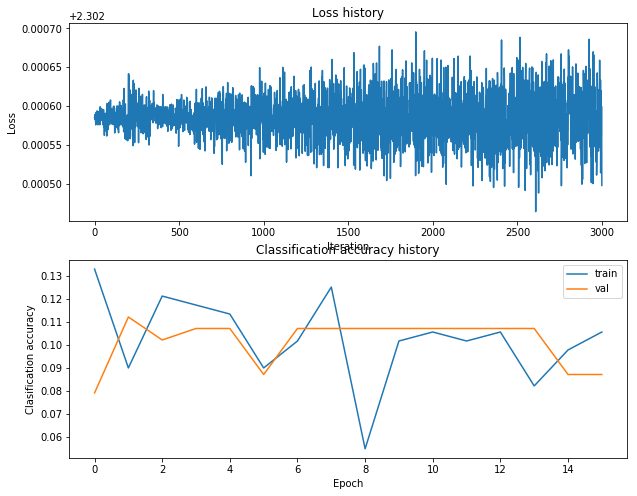

iteration 0 / 3000: loss 2.302587
iteration 100 / 3000: loss 2.302588
iteration 200 / 3000: loss 2.302584
iteration 300 / 3000: loss 2.302593
iteration 400 / 3000: loss 2.302592
iteration 500 / 3000: loss 2.302606
iteration 600 / 3000: loss 2.302587
iteration 700 / 3000: loss 2.302609
iteration 800 / 3000: loss 2.302563
iteration 900 / 3000: loss 2.302603
iteration 1000 / 3000: loss 2.302640
iteration 1100 / 3000: loss 2.302572
iteration 1200 / 3000: loss 2.302612
iteration 1300 / 3000: loss 2.302523
iteration 1400 / 3000: loss 2.302586
iteration 1500 / 3000: loss 2.302573
iteration 1600 / 3000: loss 2.302604
iteration 1700 / 3000: loss 2.302564
iteration 1800 / 3000: loss 2.302607
iteration 1900 / 3000: loss 2.302581
iteration 2000 / 3000: loss 2.302698
iteration 2100 / 3000: loss 2.302531
iteration 2200 / 3000: loss 2.302561
iteration 2300 / 3000: loss 2.302590
iteration 2400 / 3000: loss 2.302600
iteration 2500 / 3000: loss 2.302613
iteration 2600 / 3000: loss 2.302672
iteration 270

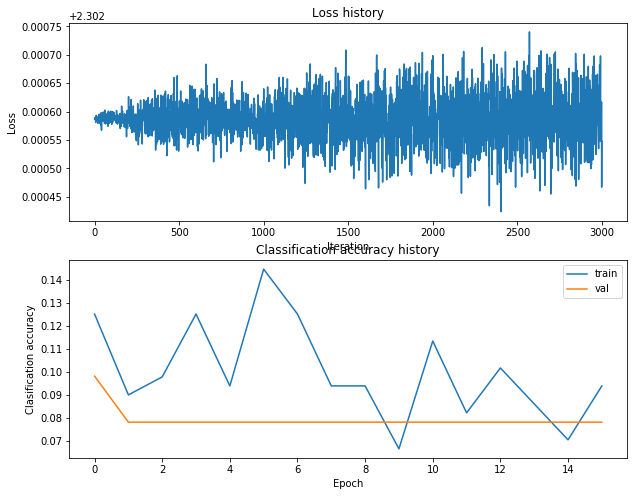

iteration 0 / 3000: loss 2.302606
iteration 100 / 3000: loss 2.302611
iteration 200 / 3000: loss 2.302614
iteration 300 / 3000: loss 2.302600
iteration 400 / 3000: loss 2.302625
iteration 500 / 3000: loss 2.302606
iteration 600 / 3000: loss 2.302553
iteration 700 / 3000: loss 2.302573
iteration 800 / 3000: loss 2.302625
iteration 900 / 3000: loss 2.302574
iteration 1000 / 3000: loss 2.302601
iteration 1100 / 3000: loss 2.302679
iteration 1200 / 3000: loss 2.302642
iteration 1300 / 3000: loss 2.302603
iteration 1400 / 3000: loss 2.302613
iteration 1500 / 3000: loss 2.302611
iteration 1600 / 3000: loss 2.302629
iteration 1700 / 3000: loss 2.302564
iteration 1800 / 3000: loss 2.302498
iteration 1900 / 3000: loss 2.302702
iteration 2000 / 3000: loss 2.302570
iteration 2100 / 3000: loss 2.302611
iteration 2200 / 3000: loss 2.302508
iteration 2300 / 3000: loss 2.302540
iteration 2400 / 3000: loss 2.302574
iteration 2500 / 3000: loss 2.302582
iteration 2600 / 3000: loss 2.302553
iteration 270

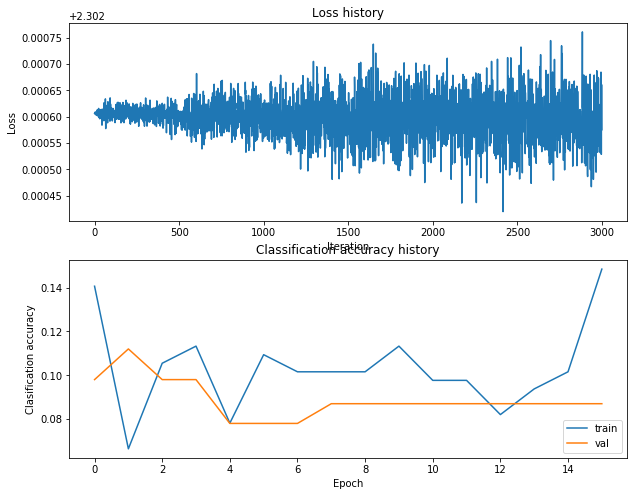

iteration 0 / 3000: loss 2.302585
iteration 100 / 3000: loss 2.301997
iteration 200 / 3000: loss 2.300718
iteration 300 / 3000: loss 2.199104
iteration 400 / 3000: loss 1.948374
iteration 500 / 3000: loss 1.705722
iteration 600 / 3000: loss 1.759757
iteration 700 / 3000: loss 1.526573
iteration 800 / 3000: loss 1.484213
iteration 900 / 3000: loss 1.389524
iteration 1000 / 3000: loss 1.557643
iteration 1100 / 3000: loss 1.416692
iteration 1200 / 3000: loss 1.490629
iteration 1300 / 3000: loss 1.308734
iteration 1400 / 3000: loss 1.371178
iteration 1500 / 3000: loss 1.417719
iteration 1600 / 3000: loss 1.419739
iteration 1700 / 3000: loss 1.435412
iteration 1800 / 3000: loss 1.340562
iteration 1900 / 3000: loss 1.398089
iteration 2000 / 3000: loss 1.434316
iteration 2100 / 3000: loss 1.393518
iteration 2200 / 3000: loss 1.313800
iteration 2300 / 3000: loss 1.444713
iteration 2400 / 3000: loss 1.470031
iteration 2500 / 3000: loss 1.312769
iteration 2600 / 3000: loss 1.361171
iteration 270

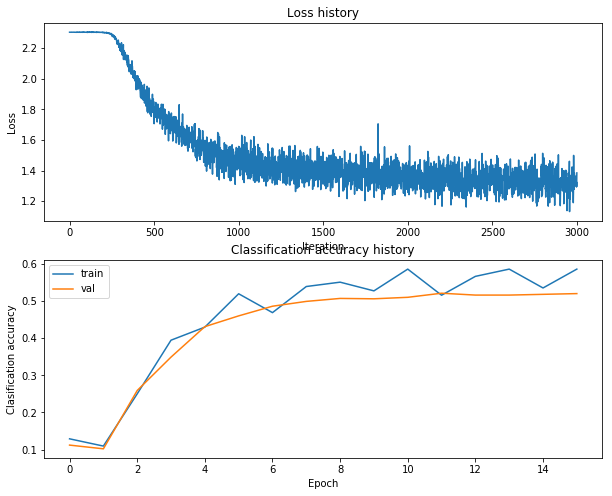

iteration 0 / 3000: loss 2.302587
iteration 100 / 3000: loss 2.302861
iteration 200 / 3000: loss 2.301636
iteration 300 / 3000: loss 2.259380
iteration 400 / 3000: loss 2.016409
iteration 500 / 3000: loss 1.887615
iteration 600 / 3000: loss 1.817788
iteration 700 / 3000: loss 1.861845
iteration 800 / 3000: loss 1.832279
iteration 900 / 3000: loss 1.598070
iteration 1000 / 3000: loss 1.558297
iteration 1100 / 3000: loss 1.523909
iteration 1200 / 3000: loss 1.613205
iteration 1300 / 3000: loss 1.620807
iteration 1400 / 3000: loss 1.610703
iteration 1500 / 3000: loss 1.708513
iteration 1600 / 3000: loss 1.613449
iteration 1700 / 3000: loss 1.581246
iteration 1800 / 3000: loss 1.578302
iteration 1900 / 3000: loss 1.672902
iteration 2000 / 3000: loss 1.416807
iteration 2100 / 3000: loss 1.617347
iteration 2200 / 3000: loss 1.528865
iteration 2300 / 3000: loss 1.483425
iteration 2400 / 3000: loss 1.514529
iteration 2500 / 3000: loss 1.549411
iteration 2600 / 3000: loss 1.659218
iteration 270

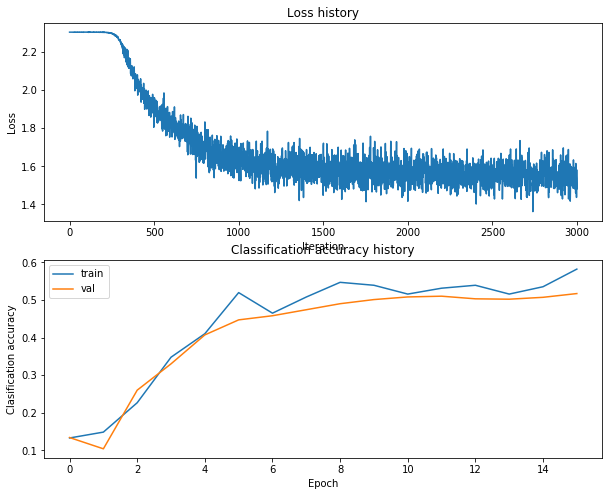

iteration 0 / 3000: loss 2.302606
iteration 100 / 3000: loss 2.302505
iteration 200 / 3000: loss 2.302814
iteration 300 / 3000: loss 2.302725
iteration 400 / 3000: loss 2.301591
iteration 500 / 3000: loss 2.296478
iteration 600 / 3000: loss 2.272397
iteration 700 / 3000: loss 2.258015
iteration 800 / 3000: loss 2.238499
iteration 900 / 3000: loss 2.250345
iteration 1000 / 3000: loss 2.215674
iteration 1100 / 3000: loss 2.182396
iteration 1200 / 3000: loss 2.171779
iteration 1300 / 3000: loss 2.201343
iteration 1400 / 3000: loss 2.192088
iteration 1500 / 3000: loss 2.173455
iteration 1600 / 3000: loss 2.210996
iteration 1700 / 3000: loss 2.149892
iteration 1800 / 3000: loss 2.153414
iteration 1900 / 3000: loss 2.176474
iteration 2000 / 3000: loss 2.134093
iteration 2100 / 3000: loss 2.177182
iteration 2200 / 3000: loss 2.164153
iteration 2300 / 3000: loss 2.121542
iteration 2400 / 3000: loss 2.149870
iteration 2500 / 3000: loss 2.162270
iteration 2600 / 3000: loss 2.155881
iteration 270

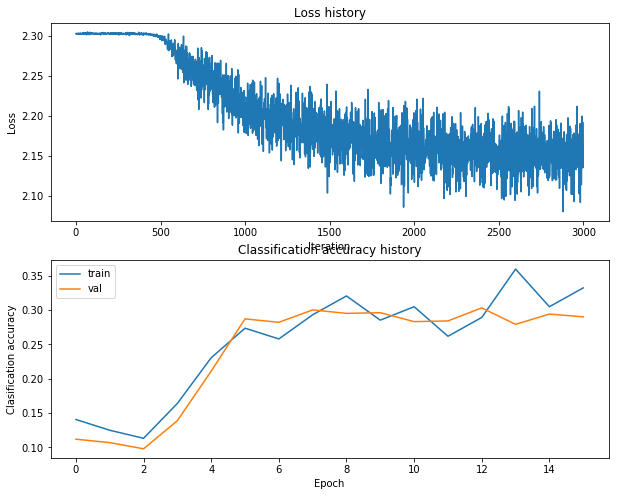

iteration 0 / 3000: loss 2.302585
iteration 100 / 3000: loss 1.557508
iteration 200 / 3000: loss 1.430803
iteration 300 / 3000: loss 1.385053
iteration 400 / 3000: loss 1.466815
iteration 500 / 3000: loss 1.448641
iteration 600 / 3000: loss 1.299308
iteration 700 / 3000: loss 1.249320
iteration 800 / 3000: loss 1.370108
iteration 900 / 3000: loss 1.151299
iteration 1000 / 3000: loss 1.333546
iteration 1100 / 3000: loss 1.121639
iteration 1200 / 3000: loss 1.174429
iteration 1300 / 3000: loss 1.204214
iteration 1400 / 3000: loss 1.254556
iteration 1500 / 3000: loss 1.092668
iteration 1600 / 3000: loss 1.120802
iteration 1700 / 3000: loss 1.048047
iteration 1800 / 3000: loss 1.221258
iteration 1900 / 3000: loss 1.181517
iteration 2000 / 3000: loss 1.136217
iteration 2100 / 3000: loss 1.114711
iteration 2200 / 3000: loss 1.215068
iteration 2300 / 3000: loss 1.152469
iteration 2400 / 3000: loss 1.185058
iteration 2500 / 3000: loss 1.085767
iteration 2600 / 3000: loss 1.120562
iteration 270

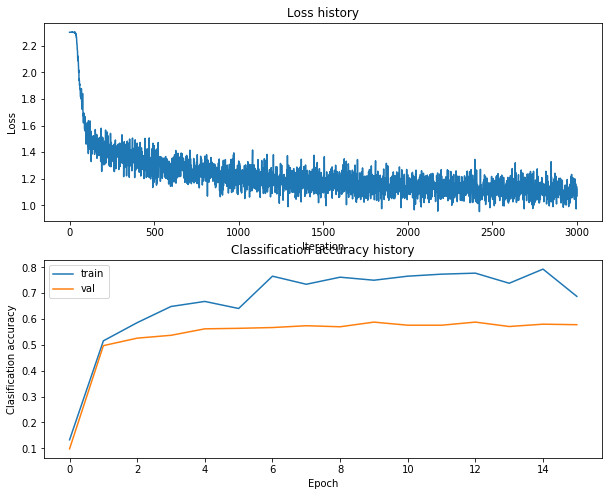

iteration 0 / 3000: loss 2.302587
iteration 100 / 3000: loss 1.727851
iteration 200 / 3000: loss 1.588288
iteration 300 / 3000: loss 1.586551
iteration 400 / 3000: loss 1.575373
iteration 500 / 3000: loss 1.676579
iteration 600 / 3000: loss 1.498020
iteration 700 / 3000: loss 1.580767
iteration 800 / 3000: loss 1.628343
iteration 900 / 3000: loss 1.615314
iteration 1000 / 3000: loss 1.634975
iteration 1100 / 3000: loss 1.601737
iteration 1200 / 3000: loss 1.520900
iteration 1300 / 3000: loss 1.562250
iteration 1400 / 3000: loss 1.554198
iteration 1500 / 3000: loss 1.611787
iteration 1600 / 3000: loss 1.559890
iteration 1700 / 3000: loss 1.525724
iteration 1800 / 3000: loss 1.528428
iteration 1900 / 3000: loss 1.662292
iteration 2000 / 3000: loss 1.619565
iteration 2100 / 3000: loss 1.608519
iteration 2200 / 3000: loss 1.563224
iteration 2300 / 3000: loss 1.487011
iteration 2400 / 3000: loss 1.575464
iteration 2500 / 3000: loss 1.623498
iteration 2600 / 3000: loss 1.632625
iteration 270

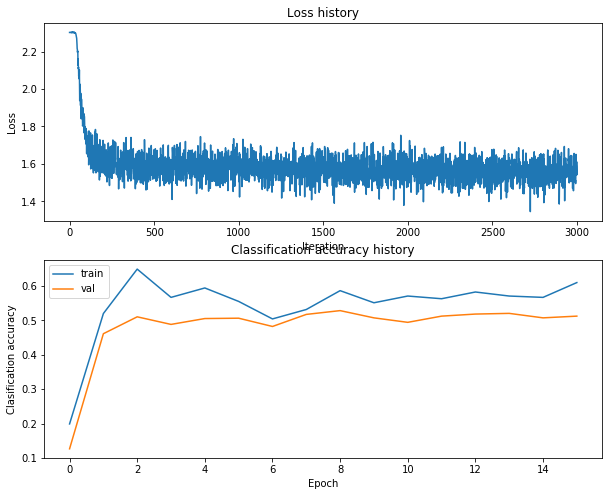

iteration 0 / 3000: loss 2.302606
iteration 100 / 3000: loss 2.252813
iteration 200 / 3000: loss 2.170365
iteration 300 / 3000: loss 2.160882
iteration 400 / 3000: loss 2.177050
iteration 500 / 3000: loss 2.135631
iteration 600 / 3000: loss 2.166702
iteration 700 / 3000: loss 2.167447
iteration 800 / 3000: loss 2.177827
iteration 900 / 3000: loss 2.128054
iteration 1000 / 3000: loss 2.178059
iteration 1100 / 3000: loss 2.191378
iteration 1200 / 3000: loss 2.103042
iteration 1300 / 3000: loss 2.156730
iteration 1400 / 3000: loss 2.134175
iteration 1500 / 3000: loss 2.183917
iteration 1600 / 3000: loss 2.136554
iteration 1700 / 3000: loss 2.182691
iteration 1800 / 3000: loss 2.161869
iteration 1900 / 3000: loss 2.142737
iteration 2000 / 3000: loss 2.096405
iteration 2100 / 3000: loss 2.141460
iteration 2200 / 3000: loss 2.102620
iteration 2300 / 3000: loss 2.134527
iteration 2400 / 3000: loss 2.147422
iteration 2500 / 3000: loss 2.167264
iteration 2600 / 3000: loss 2.161453
iteration 270

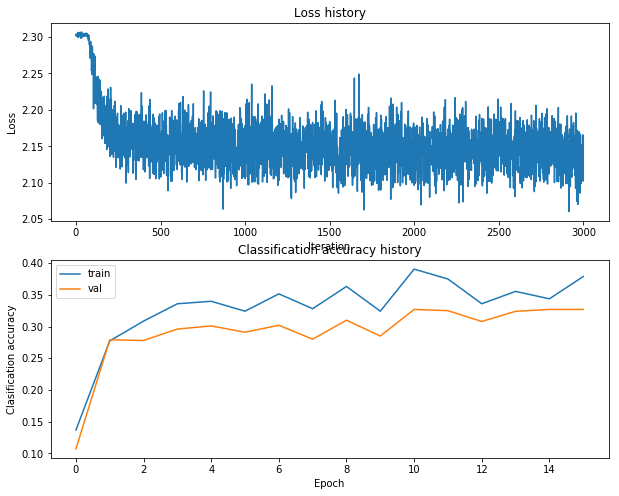

Validation accuracy:  0.588


In [ ]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

#net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
best_parameters = {}
best_ValAcc = -1
my_learningRate = np.array([1e-3, 7e-2, 5e-1])
my_reg = np.array([0.001, 0.01, 0.1])
hyper_parameters = [(a, b) for a in my_learningRate 
                   for b in my_reg]
input_size = X_train_feats.shape[1]
num_classes = 10
learning_rate_decay = 0.95
for rate, reg in hyper_parameters:
  net = TwoLayerNet(input_size, 128, num_classes)
  # Train the network
  stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=3000, batch_size=256,
            learning_rate=rate, learning_rate_decay=learning_rate_decay,
            reg=reg, verbose=True)
  #Plot the loss function and train / validation accuracies
  plt.subplot(2, 1, 1)
  plt.plot(stats['loss_history'])
  plt.title('Loss history')
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
   
  plt.subplot(2, 1, 2)
  plt.plot(stats['train_acc_history'], label='train')
  plt.plot(stats['val_acc_history'], label='val')
  plt.title('Classification accuracy history')
  plt.xlabel('Epoch')
  plt.ylabel('Clasification accuracy')
  plt.legend()
  plt.show()
  # Predict on the validation set
  val_acc = (net.predict(X_val_feats) == y_val).mean()
  if (val_acc > best_ValAcc):
    best_ValAcc = val_acc
    best_net = net
    best_parameters[(rate, reg)] = stats
print('Validation accuracy: ', best_ValAcc)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [ ]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.
print(best_parameters)
test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

{(0.5, 0.001): {'train_acc_history': [0.1328125, 0.515625, 0.5859375, 0.6484375, 0.66796875, 0.640625, 0.765625, 0.734375, 0.76171875, 0.75, 0.765625, 0.7734375, 0.77734375, 0.73828125, 0.79296875, 0.6875], 'loss_history': [2.302585262872644, 2.302540812988115, 2.303178109004453, 2.302512561174154, 2.30271740220468, 2.3029163652749913, 2.3023322532741326, 2.3024832948458025, 2.3033525160775365, 2.3044801873052214, 2.3027962223681753, 2.3027796974934907, 2.3034146760703376, 2.303120606097662, 2.3029271264733446, 2.3054259723469905, 2.3023955736257915, 2.303827674762204, 2.3031604890826256, 2.302175313929625, 2.3038170076638407, 2.3023976358691822, 2.3031050663141084, 2.3029251899495415, 2.302908438462652, 2.302705106768115, 2.3028837530548887, 2.3021075673010927, 2.299143284145682, 2.2966487337881767, 2.302557259445607, 2.2988380553842442, 2.3046396771323563, 2.2974274700492865, 2.293795514863042, 2.2988316877581174, 2.288656998707281, 2.2828143366085136, 2.2899851118832117, 2.279817219